In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import sys 
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
sys.path.insert(0, "../src")
import severson_data
import models
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [4]:
colours = ['#208F90', '#8F2317','#17608F','#8F5F17','#f2f3f4','#E56399','#DE6E4B']
golden_ratio =1.618

sns.set_palette(sns.color_palette(colours))


colors = cycler('color',
                colours)
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#000000',
       axisbelow=True, grid=True, prop_cycle=colors)

In [5]:
config = configparser.ConfigParser()
config.read('../config.ini');
result_path =config['PATHS']['result_path'] 

In [6]:
model_path  = '../models/dnn_models/'
fig_path =config['PATHS']['figure_path'] 
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [7]:
results_all = pd.concat(results_list, axis=1).T.infer_objects()

results = results_all


my_results = None

my_results = results[[
     'sequence_length', 'best_val_loss',
     'rmse_state_val', 'rmse_state_train', 'rmse_state_test','dropout', 'hidden_size', 
      ]].groupby([ 'sequence_length', 'dropout','hidden_size' ]).mean()
    


my_results

best_val_loss  rmse_state_val  \
sequence_length dropout hidden_size                                  
40              0.00    128                  41.53          158.68   
                        256                  47.20          147.87   
                        512                  55.45          154.79   
100             0.00    128                  37.21          126.58   
                        256                  35.42          116.69   
                        512                  44.67          151.24   

                                     rmse_state_train  rmse_state_test  
sequence_length dropout hidden_size                                     
40              0.00    128                    145.74           311.73  
                        256                    135.47           313.32  
                        512                    167.84           351.39  
100             0.00    128                    154.79           227.73  
                        256                    133.96           207.60  
                        512                    168.26           244.79

# load data

In [8]:
best_model_idx = results.rmse_state_val.argmin()

In [9]:
if 'data_dict' not in locals(): # just takes a lot of time
    data_path = config['DATASET']['severson_path'] 
    bat_dicts = severson_data.load_data_single(data_path)
data_dict = {**bat_dicts[0], **bat_dicts[1], }

x, y, c, var  = severson_data.get_capacity_input(data_dict, num_offset=0, start_cycle = results_all.start[best_model_idx], stop_cycle = 100)

x_scaled  = severson_data.scale_x(x,y)

x_preprocessed = severson_data.remove_outliers(x_scaled,y)
x_preprocessed[np.where(x_preprocessed ==-1)] =0

C:\Users\lauri\AppData\Roaming\Python\Python39\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [10]:
train_idxs , val_idxs,test_idxs= severson_data.get_split(len(x), seed =42)
qc_variance_scaler = StandardScaler().fit(var[train_idxs])
var = qc_variance_scaler.transform(var)
augmented_data = np.hstack([c, var, x_preprocessed[:, :1]])

# augmented_data = np.hstack([c, var,])


In [11]:
seq_len = results.sequence_length[best_model_idx]
input_dim = augmented_data.shape[1]

In [12]:
results =results[results.dropout  == .0]
results =results[results.hidden_size  == 256]
results =results[results.sequence_length  == 40]
results = results.reset_index()

In [13]:


my_models = [models.CapacityDNN(
    num_input=input_dim,
    num_hidden=results.hidden_size[i],
    num_output=2237,
).to(device) for i, _ in enumerate(results.file_name)] 
for i, file_name in enumerate(results.file_name):
    my_models[i].load_state_dict(torch.load(oj(model_path,file_name+".pt")))
    my_models[i] = my_models[i].to(device).eval()
    

In [14]:

output_list = []

used_idxs =  test_idxs#for actually new data, use test_idxs

for model in my_models:


    with torch.no_grad():
        my_output = model(torch.from_numpy(augmented_data[used_idxs]).to(device).float()).cpu().numpy()
        output_list.append(my_output)


all_outputs = np.asarray(output_list)


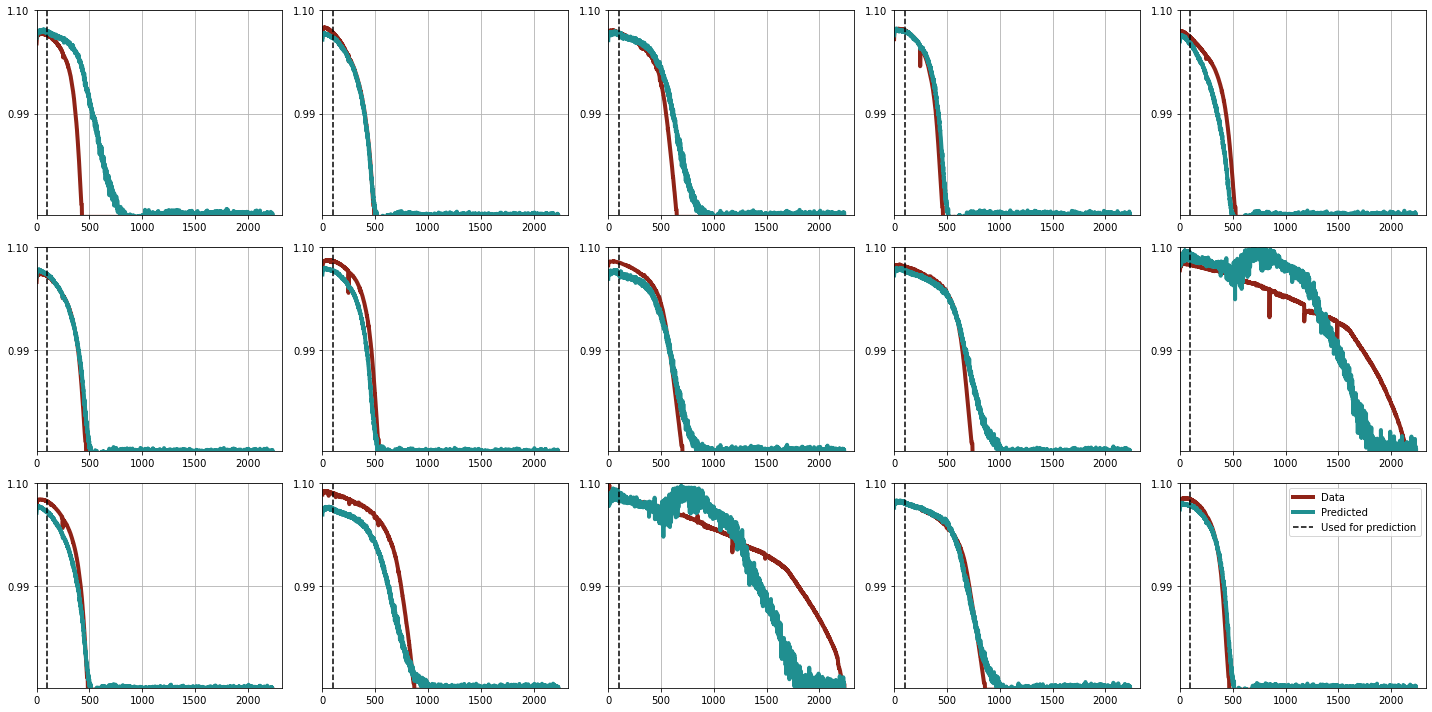

In [15]:
model_idx = 3 #results.best_val_loss.argmin()
fig, axes = plt.subplots(ncols=5, nrows =3, figsize = (20, 10))
linewidth = 4

for i, ax in enumerate(fig.get_axes()):
    if i >= len(used_idxs):
        break
    
    ax.plot(x_preprocessed[used_idxs[i]]* (1.1-.8*1.1) + .8*1.1, c = colours[1], label = 'Data',linewidth = linewidth)

    ax.plot(all_outputs[model_idx,i,:,]* (1.1-.8*1.1) + .8*1.1, c= colours[0], label = 'Predicted',linewidth = linewidth)
    ax.set_yticks([.8*1.1,.9*1.1,  1.1])
    ax.set_ylim(.8*1.1+.002,1.1)#hide the lines


    ax.set_xlim(0,  2326)#np.minimum(y[used_idxs[i]]+200, y.max()))
    ax.axvline(x = seq_len , linestyle = "--", c = 'k', label = 'Used for prediction')
axes[-1,-1].legend(loc =1)
plt.tight_layout()

# plt.savefig(oj(fig_path,"DNNPRedictions{0!s}.pdf".format(seq_length, )) )

In [16]:
y_lifetime_pred_state = (all_outputs < 1e-3).argmax(axis=2) 
np.sqrt(np.square(y_lifetime_pred_state- y[used_idxs]).mean(axis=1)).mean()

223.16632868675492

In [17]:

# ensemble
np.sqrt(np.square(y_lifetime_pred_state.mean(axis=0)- y[used_idxs]).mean())

220.07836699468584

# Aged batteries

In [18]:
aged_data_dict = {**bat_dicts[2], }
aged_x, aged_y, aged_c, aged_var  = severson_data.get_capacity_input(aged_data_dict, num_offset=0, start_cycle = results_all.start[best_model_idx], stop_cycle = seq_len)

aged_test_idxs = np.arange(len(aged_x))
aged_x = severson_data.preprocess_x(aged_x,aged_y)
aged_var = qc_variance_scaler.transform(aged_var)
aged_augmented_data =np.hstack([aged_c, aged_var,aged_x[:, :1]]) 




In [19]:

output_list = []

used_idxs =  aged_test_idxs#for actually new data, use test_idxs

for model in my_models:


    with torch.no_grad():
        my_output = model(torch.from_numpy(aged_augmented_data[aged_test_idxs]).to(device).float()).cpu().numpy()
        output_list.append(my_output)


all_outputs = np.asarray(output_list)


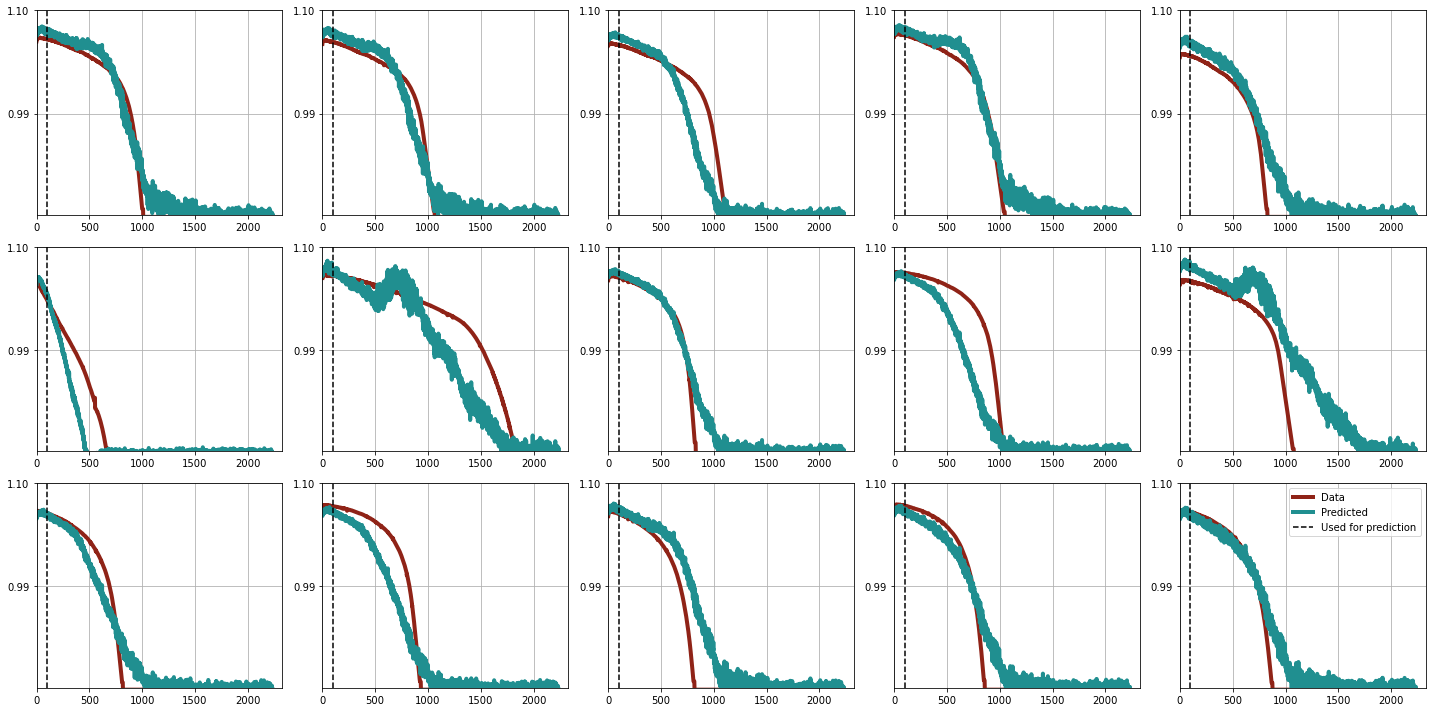

In [20]:
model_idx = results.best_val_loss.argmin()
fig, axes = plt.subplots(ncols=5, nrows =3, figsize = (20, 10))
linewidth = 4

for i, ax in enumerate(fig.get_axes()):
    if i >= len(used_idxs):
        break
    
    ax.plot(aged_x[used_idxs[i]]* (1.1-.8*1.1) + .8*1.1, c = colours[1], label = 'Data',linewidth = linewidth)

    ax.plot(all_outputs[model_idx,i,:,]* (1.1-.8*1.1) + .8*1.1, c= colours[0], label = 'Predicted',linewidth = linewidth)
    ax.set_yticks([.8*1.1,.9*1.1,  1.1])
    ax.set_ylim(.8*1.1+.002,1.1)#hide the lines


    ax.set_xlim(0,  2326)#np.minimum(y[used_idxs[i]]+200, y.max()))
    ax.axvline(x = seq_len , linestyle = "--", c = 'k', label = 'Used for prediction')
axes[-1,-1].legend(loc =1)
plt.tight_layout()

# plt.savefig(oj(fig_path,"DNNPRedictions{0!s}.pdf".format(seq_length, )) )

In [21]:
y_lifetime_pred_state = (all_outputs < 1e-3).argmax(axis=2) 
np.sqrt(np.square(y_lifetime_pred_state- aged_y[used_idxs]).mean(axis=1)).mean()

291.32520538628563